In [1]:
import numpy as np
import cv2
import pickle
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import img_as_ubyte
from scipy.optimize import curve_fit
%matplotlib inline

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

ym_per_pix = 30.0/720.0 # meters per pixel in y dimension
xm_per_pix = 3.7/700.0 # meters per pixel in x dimension


In [2]:
def func(x, a, b, c):
    return a*x**2+b*x+c

def display_save_images(images,titles=None, fname=None):
    """ Displays the input images in a subplot.
        After the images have been displayed, this
        function saves them in the 'output_images'
        directory.
        
    Parameter:
        - images: a list of images.
        - titles: a list of titles.
    """
    img_count = len(images)
    m_cols = 2
    m_rows = int(img_count/m_cols) + (int(img_count/m_cols)==0)
    
    plt.figure(figsize=(6*m_cols, 4*m_rows))
    
    for idx in range(img_count):
        plt.subplot(m_rows, m_cols, idx+1)

        if titles is not None:
            plt.title(titles[idx])

        plt.axis('off')

        if len(images[idx].shape)==3:
            plt.imshow(images[idx])
        else:
            plt.imshow(images[idx], cmap='binary')

    plt.tight_layout(pad=0.50)

    if fname is not None:
        plt.savefig('output_images/' + fname + '.jpg')

    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    plt.show()
    return

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

def load_camera_cal_params(pickle_fname):
    """ Loads from a pickle file the camera
        distortion matrix and distances.

    Parameter:
        - pickle_fname: Pickle file name.
    Returns:
        - (mtx, dist) tuple.
    """
    with open(pickle_fname, "rb") as pf:
        data = pickle.load(pf)
        return data['mtx'], data['dist']
    
def pipeline_undistort(img, mtx, dist):
    """ Undistorts the input image. """
    return cv2.undistort(img, mtx, dist, None, mtx)

def hls_lthresh(img, thresh=(220, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    hls_l = hls[:,:,1]
    hls_l = hls_l*(255/np.max(hls_l))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(hls_l)
    binary_output[(hls_l > thresh[0]) & (hls_l <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    return binary_output

def lab_bthresh(img, thresh=(190,255)):
    # 1) Convert to LAB color space
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)
    lab_b = lab[:,:,2]
    # don't normalize if there are no yellows in the image
    if np.max(lab_b) > 175:
        lab_b = lab_b*(255/np.max(lab_b))
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(lab_b)
    binary_output[((lab_b > thresh[0]) & (lab_b <= thresh[1]))] = 1
    # 3) Return a binary image of threshold result
    return binary_output

# Edit this function to create your own pipeline.
def pipeline_transform(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    #s_thresh=(170, 255), sx_thresh=(20, 50)
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hsv[:,:,1]
    s_channel = hsv[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))
    
    img_lthresh = hls_lthresh(img)
    img_bthresh = lab_bthresh(img)
    
    flat_binary = np.zeros_like(sxbinary)
    flat_binary[(sxbinary == 1) | (s_binary == 1)] = 1
    
    final_binary = np.zeros_like(img_bthresh)
    final_binary[(img_lthresh == 1) | (img_bthresh == 1)] = 1
    
    return final_binary

def birds_eye_view(img, leftupper_x=568, rightupper_x=717):
    """ Apply perspective transformation on input image.
        Returns: The transformed input image (Bird's Eye) as uint8 type.
    """
    img_h = img.shape[0]
    img_w = img.shape[1]
    
    leftupperpoint  = [leftupper_x,470]
    rightupperpoint = [rightupper_x,470]
    
    leftlowerpoint  = [260,680]
    rightlowerpoint = [1043,680]

    src = np.float32([leftupperpoint, leftlowerpoint, rightupperpoint, rightlowerpoint])
    dst = np.float32([[200,0], [200,680], [1000,0], [1000,680]])

    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)

    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (img_w, img_h), flags=cv2.INTER_NEAREST)
    return img_as_ubyte(warped), M


In [3]:
def fit_lines(binary_warped, left_fit_init=None, right_fit_init=None):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint]) # max value
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint # max value
    
    #print(leftx_base,midpoint,rightx_base)
    
    # Choose the number of sliding windows
    nwindows = 10
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
        
    # Fit a second order polynomial to each
    #left_fit = np.polyfit(lefty, leftx, 2)
    #right_fit = np.polyfit(righty, rightx, 2)
    
    
    left_fit = []
    right_fit = []
    const_center=800
    large_min= 600.0
    large_max= 1000.0
    
    
    if len(left_lane_inds) >= len(right_lane_inds):
        if left_fit_init is None:
            left_fit, pcov_l = curve_fit(func, lefty, leftx)
        else :
            left_fit, pcov_l = curve_fit(func, lefty, leftx, p0=left_fit_init)
        
        if right_fit_init is None:
            
            right_fit, pcov_r = curve_fit(func, righty, rightx, p0=[left_fit[0],left_fit[1],left_fit[2]+800.0],
                                          bounds=([min(left_fit[0]*0.97,left_fit[0]*1.03),
                                                   min(left_fit[1]*0.97,left_fit[1]*1.03),
                                                   left_fit[2]+large_min],
                                                  [max(left_fit[0]*0.97,left_fit[0]*1.03),
                                                   max(left_fit[1]*0.97,left_fit[1]*1.03),
                                                   left_fit[2]+large_max]))
        else :
            right_fit, pcov_r = curve_fit(func, righty, rightx, p0=right_fit_init)
            
    else :
        if right_fit_init is None:
            right_fit, pcov_r = curve_fit(func, righty, rightx)
        else :
            right_fit, pcov_r = curve_fit(func, righty, rightx, p0=right_fit_init)
        
        if left_fit_init is None:
            left_fit, pcov_l = curve_fit(func, lefty, leftx, p0=[right_fit[0],right_fit[1],right_fit[2]-800],
                                          bounds=([min(right_fit[0]*0.97,right_fit[0]*1.03),
                                                   min(right_fit[1]*0.97,right_fit[1]*1.03),
                                                   right_fit[2]-large_max],
                                                  [max(right_fit[0]*0.97,right_fit[0]*1.03),
                                                   max(right_fit[1]*0.97,right_fit[1]*1.03),
                                                   (right_fit[2]-large_min)]
                                                   ))
        else :
            left_fit, pcov_l = curve_fit(func, lefty, leftx, p0=left_fit_init) 

    # At this point, you're done! But here is how you can visualize the result as well:
    #print(left_fit,right_fit)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print(max(ploty),max(left_fitx),max(right_fitx))
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Compute car position
    m_car = binary_warped.shape[1] / 2
    #print(m_car, left_fitx[0], right_fitx[0])
    
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])
    #print(left_curverad,right_curverad)
    return out_img, avg_radius_meters, offset_right_from_center_m, left_fitx, right_fitx, ploty, left_fit, right_fit

def to_real_world_space(image, warped, Minv, left_fitx, right_fitx, ploty):
    # Create an image to draw the lines on
    color_warp = np.zeros_like(warped).astype(np.uint8)
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

    # Combine the result with the original image
    result = cv2.addWeighted(image, 1, newwarp, 0.3, 0)

    return result

def calculate_radius(binary_warped, ploty, left_fit, right_fit, left_fitx, right_fitx ):
 
    # Choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)*ym_per_pix
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad =  ((1 + (2*left_fit_cr[0] *y_eval*ym_per_pix + left_fit_cr[1])**2) **1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    # Compute car position
    m_car = binary_warped.shape[1] / 2
    #print(m_car, left_fitx[0], right_fitx[0])
    
    m_lane = (left_fitx[0] + right_fitx[0]) / 2
    offset_right_from_center_m = (m_lane-m_car)*xm_per_pix
    
    # Now our radius of curvature is in meters
    avg_radius_meters = np.mean([left_curverad, right_curverad])

    return avg_radius_meters, offset_right_from_center_m
    

In [4]:
def pipeline_image(img):
    # Undistort
    img_undist = pipeline_undistort(img, mtx, dist)
    
    # Perspective Transform
    binary = pipeline_transform(img_undist)
   
    # bird view
    warped, M = birds_eye_view(binary)
    
    # fit lines
    img_lines, r_meters, right_from_center_m, left_fitx, right_fitx, ploty, _,_ = fit_lines(warped)
    #print(r_meters, right_from_center_m)
    
    # Go back to real world space
    Minv = np.linalg.inv(M)
    final_output = to_real_world_space(img_undist, img_lines, Minv, left_fitx, right_fitx, ploty)

    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Curve Radius: {:.0f} m".format(r_meters)
    cv2.putText(final_output, text, (50,50), font, 1, (255,255,255), 2)
    text = "Offset from center: {:.2f} m".format(right_from_center_m)
    cv2.putText(final_output, text, (50,100), font, 1, (255,255,255), 2)

    
    pts = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    cv2.polylines(img_lines, np.int32([pts]), isClosed=False, color=(255,255,0), thickness=8)

    pts = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    cv2.polylines(img_lines, np.int32([pts]), isClosed=False, color=(255,255,0), thickness=8)
    
    return img_undist, binary, warped, img_lines, final_output


In [5]:
# loading calibration
pickle_fname = 'output_images/camera_cal_mtx_dist.p'
mtx, dist = load_camera_cal_params(pickle_fname)


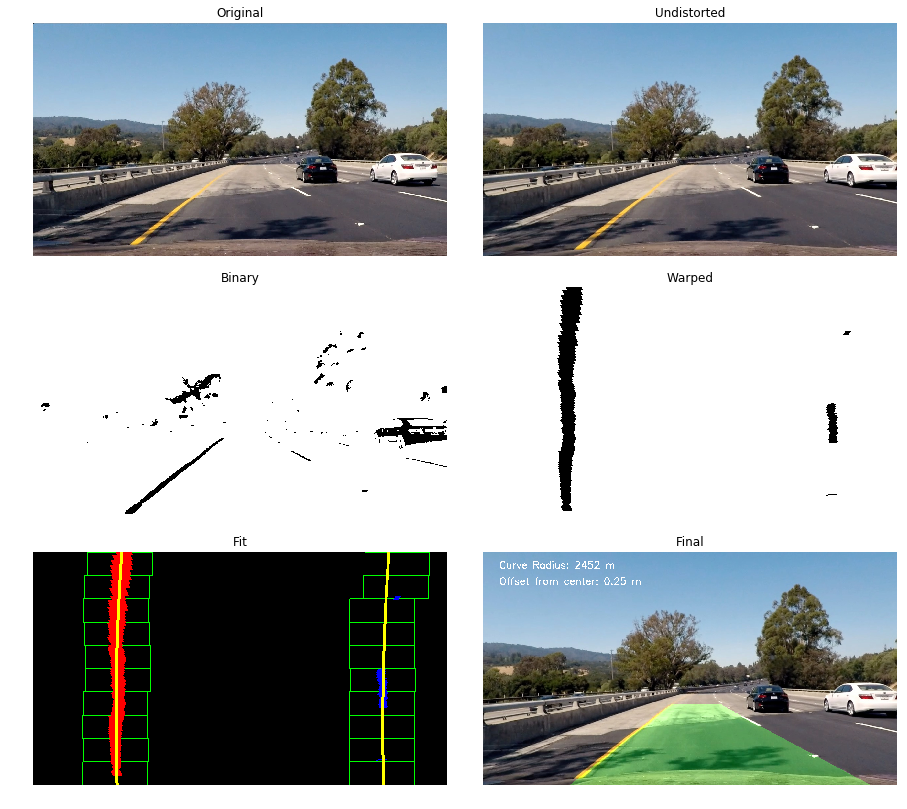

In [6]:
image='./test_images/test4.jpg'
img = mpimg.imread(image)

img_undist, binary, warped, img_lines, final_output=pipeline_image(img)

display_save_images([img, img_undist,binary, warped,img_lines, final_output],
                    ['Original', 'Undistorted','Binary','Warped','Fit','Final'], fname='out_'+image[14:-4])


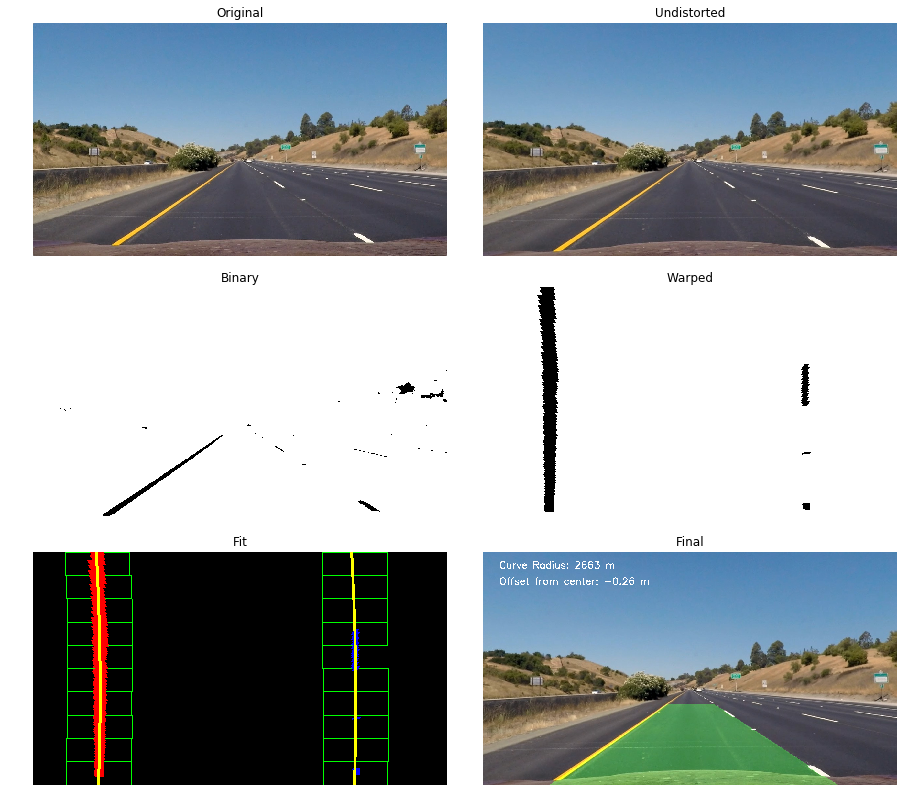

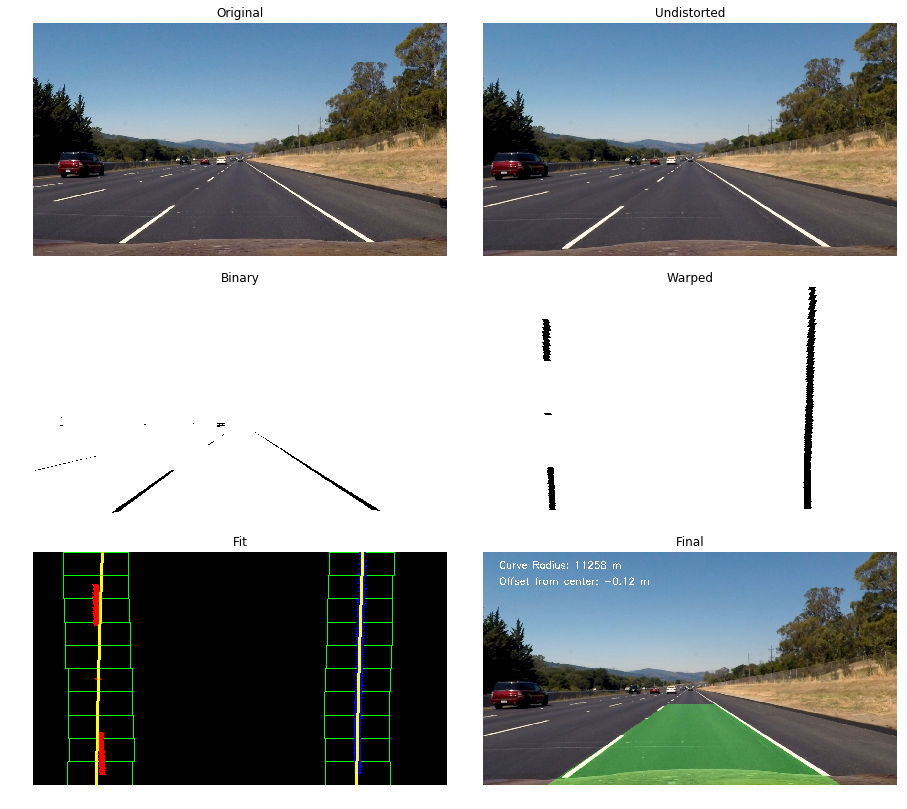

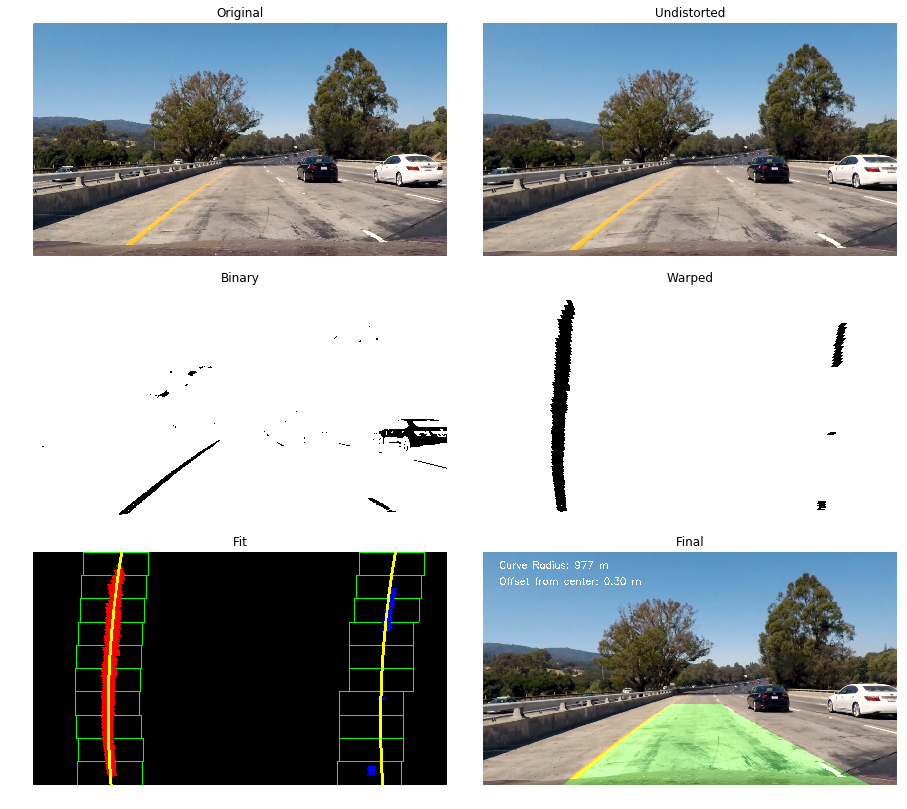

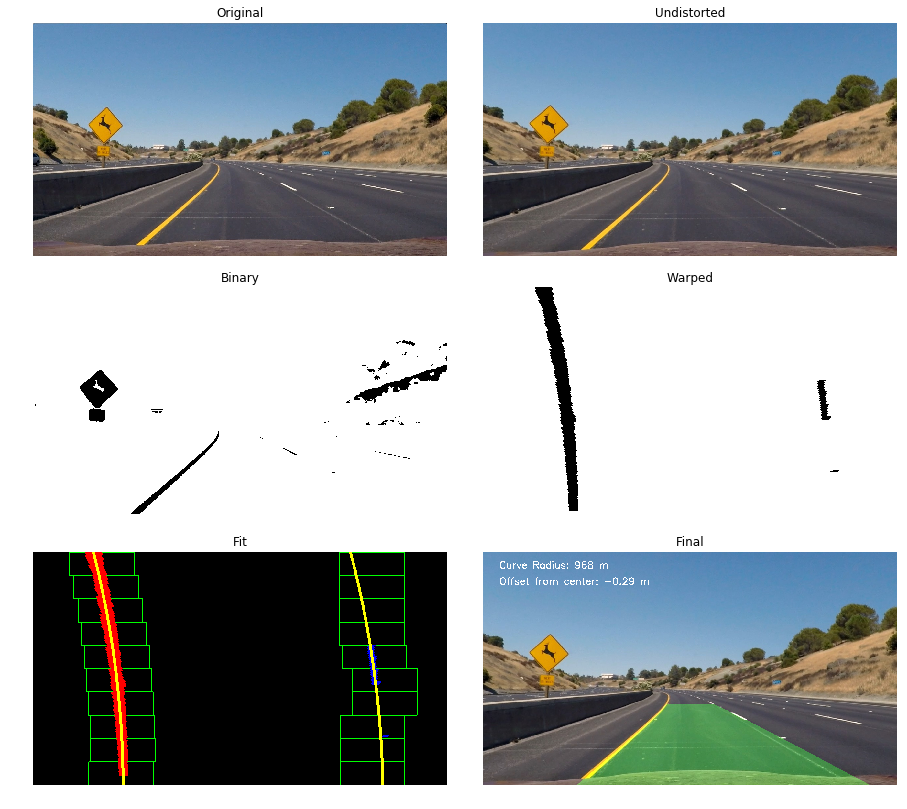

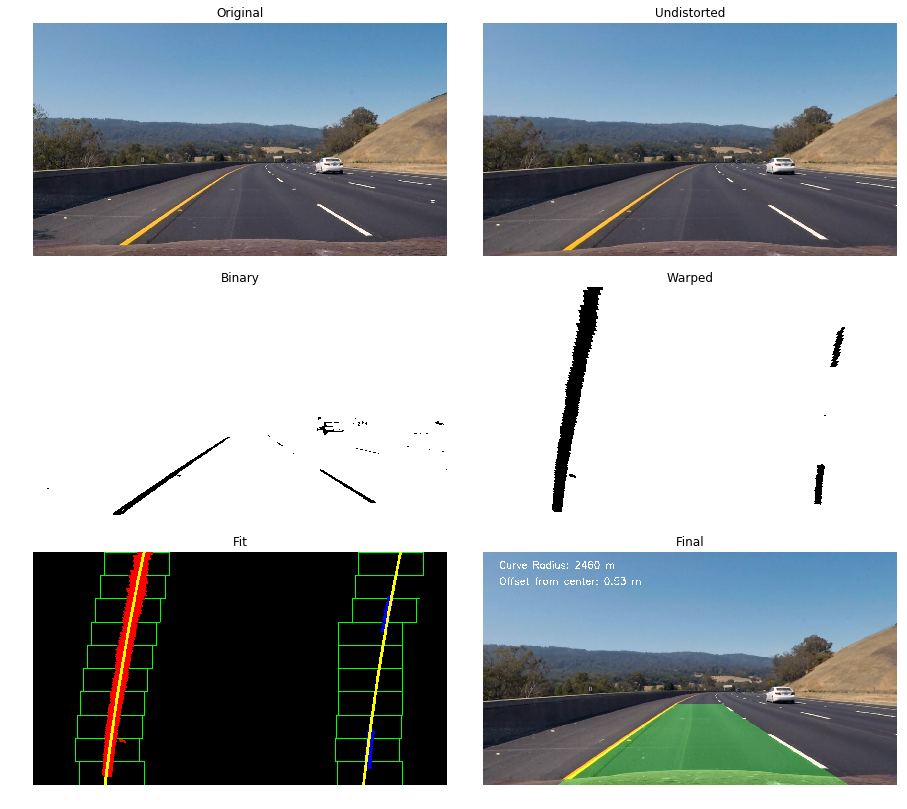

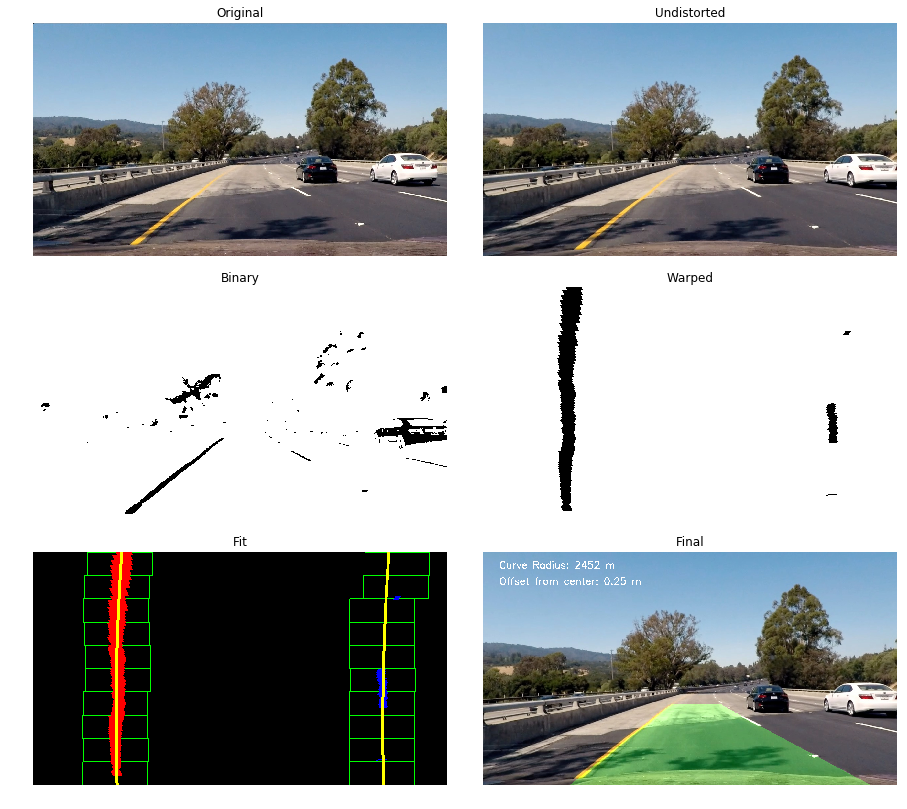

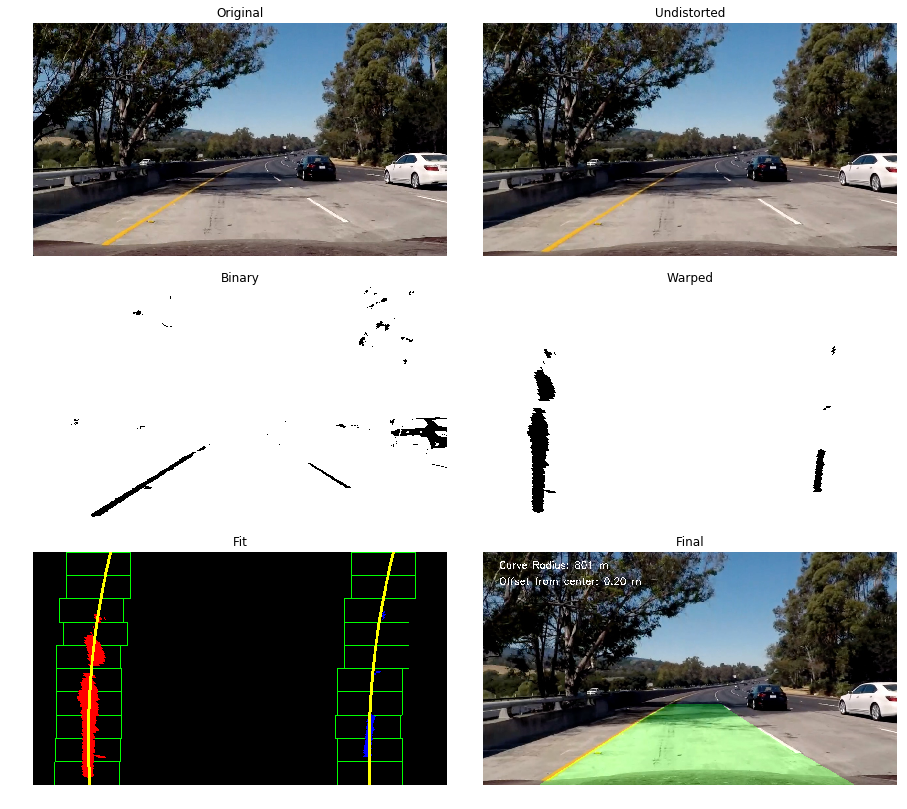

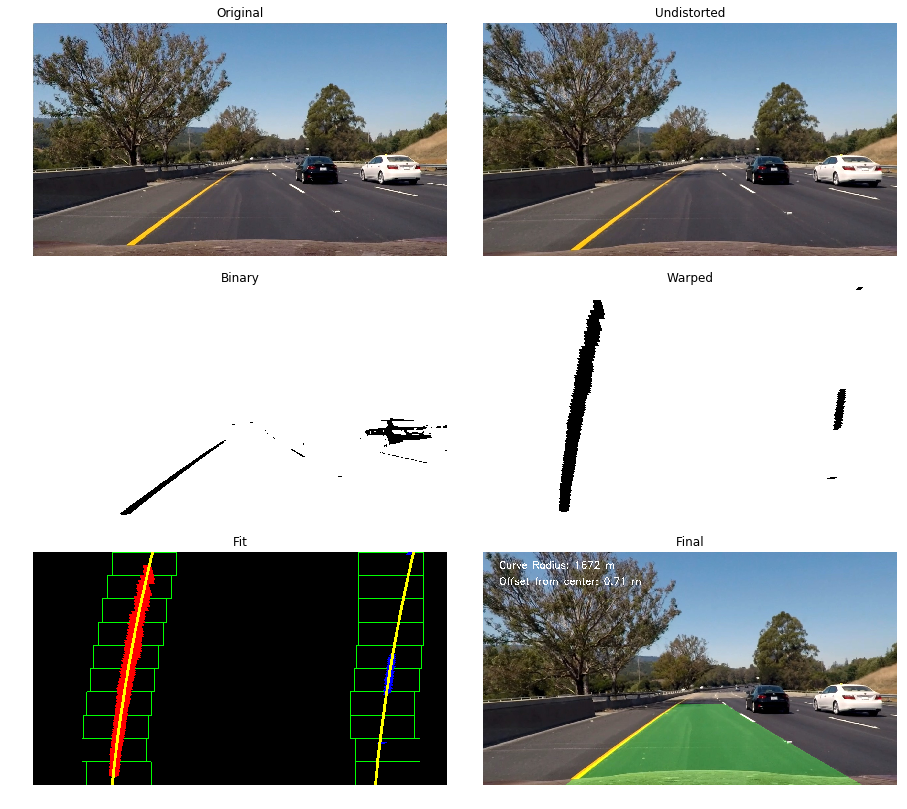

In [7]:
# Make a list of example images
images = glob.glob('./test_images/*.jpg')
                                          
for image in images:
    img = mpimg.imread(image)

    img_undist, binary, warped, img_lines, final_output=pipeline_image(img)

    display_save_images([img, img_undist,binary, warped,img_lines, final_output],
                    ['Original', 'Undistorted','Binary','Warped','Fit','Final'], fname='out_'+image[14:-4])


In [8]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #number of detected pixels
        #self.px_count = None
        self.recent_fits = []
        
    def add_fit(self, fit):
        # add a found fit to the line, up to n
        if fit is not None:
            if self.best_fit is not None:
                # if we have a best fit, see how this new fit compares
                self.diffs = abs(fit-self.best_fit)
            if (self.diffs[0] > 0.001 or \
               self.diffs[1] > 1.0 or \
               self.diffs[2] > 100.) and \
               len(self.current_fit) > 0:
                # bad fit! abort! abort! ... well, unless there are no fits in the current_fit queue, then we'll take it
                self.detected = False
            else:
                self.detected = True
                #self.px_count = np.count_nonzero(inds)
                self.current_fit.append(fit)
                if len(self.current_fit) > 10:
                    # throw out old fits, keep newest n
                    #self.current_fit = self.current_fit[len(self.current_fit)-5:]
                    self.current_fit = self.current_fit[1:]
                self.best_fit = np.average(self.current_fit, axis=0)

        # or remove one 
        else:
            self.detected = False
            if len(self.current_fit) > 0:
                # throw out oldest fit
                self.current_fit = self.current_fit[:len(self.current_fit)-1]
            if len(self.current_fit) > 0:
                # if there are still any fits in the queue, best_fit is their average
                self.best_fit = np.average(self.current_fit, axis=0)


In [9]:
def process_image(img):
    # Undistort
    img_undist = pipeline_undistort(img, mtx, dist)
    
    # Perspective Transform
    binary = pipeline_transform(img_undist)
   
    # bird view
    warped, M = birds_eye_view(binary)
    
    
    # fit lines
    r_meters=0
    right_from_center_m = 0
    img_lines =[] 
    l_fitx =[] 
    r_fitx=[] 
    ploty = []
    l_fit =[] 
    r_fit=[] 

    if len(l_line.current_fit) == 0 and len(r_line.current_fit)==0:
        img_lines, r_meters, right_from_center_m, l_fitx, r_fitx, ploty, l_fit, r_fit = fit_lines(warped)
    else :
        img_lines, r_meters, right_from_center_m, l_fitx, r_fitx, ploty, l_fit, r_fit = \
            fit_lines(warped,l_line.best_fit, r_line.best_fit)
    
    # invalidate both fits if the difference in their x-intercepts isn't around 350 px (+/- 100 px)
    
    if l_fit is not None and r_fit is not None:
        # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) > 100:
            l_fit = None
            r_fit = None
            
    l_line.add_fit(l_fit)
    r_line.add_fit(r_fit)
    Minv = np.linalg.inv(M)
    #print(len(l_line.best_fit),len(r_line.best_fit))   
    
    #r_fit=r_line.best_fit
    #l_fit=l_line.best_fit
    
    if l_line.best_fit is not None and r_line.best_fit is not None : 
        l_fitx = l_line.best_fit[0]*ploty**2 + l_line.best_fit[1]*ploty + l_line.best_fit[2]
        r_fitx = r_line.best_fit[0]*ploty**2 + r_line.best_fit[1]*ploty + r_line.best_fit[2]
        r_meters, right_from_center_m=calculate_radius(warped, ploty, l_line.best_fit, r_line.best_fit, l_fitx, r_fitx)
        
    # draw the current best fit if it exists
    #if l_fit is not None and r_fit is not None:
    final_output = to_real_world_space(img_undist, img_lines, Minv, l_fitx, r_fitx, ploty)

    # Annotate image with text
    font = cv2.FONT_HERSHEY_SIMPLEX
    text = "Curve Radius: {:.0f} m".format(r_meters)
    cv2.putText(final_output, text, (50,50), font, 1, (255,255,255), 2)
    text = "Offset from center: {:.2f} m".format(right_from_center_m)
    cv2.putText(final_output, text, (50,100), font, 1, (255,255,255), 2)
    
    pts_l = np.array([np.transpose(np.vstack([l_fitx, ploty]))])
    cv2.polylines(img_lines, np.int32([pts_l]), isClosed=False, color=(255,255,0), thickness=8)

    pts_r = np.array([np.transpose(np.vstack([r_fitx, ploty]))])
    cv2.polylines(img_lines, np.int32([pts_r]), isClosed=False, color=(255,255,0), thickness=8)
    #else: 

    return np.hstack((final_output, img_lines))
    


In [10]:
l_line = Line()
r_line = Line()

video_output1 = 'output_videos/project_video_output.mp4'
video_input1 = VideoFileClip('project_video.mp4')#.subclip(22,26)
processed_video = video_input1.fl_image(process_image)
%time processed_video.write_videofile(video_output1, audio=False)

[MoviePy] >>>> Building video output_videos/project_video_output.mp4
[MoviePy] Writing video output_videos/project_video_output.mp4


100%|█████████▉| 1260/1261 [07:03<00:00,  3.53it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video_output.mp4 

CPU times: user 7min 55s, sys: 4min 33s, total: 12min 29s
Wall time: 7min 5s


In [11]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(video_output1))